In [1]:
from math import ceil
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from utils import sigmoid, predict, sigmoid_cross_entropy_with_logits, sigmoid_cross_entropy_with_x_w, sigmoid_cross_entropy_truncated, derivative_cost_wrt_params, backtracking_line_search

In [2]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_curve, roc_auc_score, roc_curve

In [3]:
csv_path = r"C:\Users\Thanh\Downloads\voice_gender\voice.csv"

In [4]:
df = pd.read_csv(csv_path)

In [5]:
df.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


In [6]:
df['label']=df['label'].replace({'male':1,'female':0})

In [7]:
df.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,1
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,1
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,1
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,1
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,1


In [8]:
x = df.drop("label", axis=1).to_numpy(dtype=np.float)
y = df["label"].values.astype(np.float)

In [9]:
x = (x - np.min(x, axis=0, keepdims=True))/(np.max(x, axis=0, keepdims=True) - np.min(x, axis=0, keepdims=True))
#x = (x-np.mean(x, axis=0, keepdims=True))/np.std(x, axis=0, keepdims=True)

In [10]:
x

array([[9.64185977e-02, 4.73408557e-01, 8.41252523e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.25828039e-01, 5.05074648e-01, 1.16899775e-01, ...,
        2.14438885e-03, 2.14592275e-03, 5.64489929e-02],
       [1.79222164e-01, 6.75535813e-01, 1.02872692e-01, ...,
        3.57398142e-04, 3.57653791e-04, 4.98851565e-02],
       ...,
       [4.84948580e-01, 7.99042208e-01, 6.90336544e-01, ...,
        1.34024303e-01, 1.34120172e-01, 2.08884632e-01],
       [4.92516043e-01, 7.45692037e-01, 6.95311295e-01, ...,
        1.64045747e-01, 1.64163090e-01, 3.33559435e-01],
       [5.95699639e-01, 7.68963896e-01, 6.87590032e-01, ...,
        2.50178699e-02, 2.50357654e-02, 3.75385802e-01]])

In [11]:
x.shape

(3168, 20)

In [12]:
ones = np.ones(shape=[x.shape[0], 1], dtype=np.float)
x = np.append(x, ones, axis=1)
x.shape

(3168, 21)

In [13]:
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(x, y)

5

In [14]:
for train_index, test_index in skf.split(x, y):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [15]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((2535, 21), (633, 21), (2535,), (633,))

In [16]:
#weights = np.random.normal(loc=0, scale=np.sqrt(2/(x.shape[1] + 1)), size=x.shape[1])
weights = np.random.normal(loc=0, scale=np.sqrt(2/(x.shape[1])), size=x.shape[1]-1)
weights = np.append(weights, 0.)

In [17]:
weights

array([-0.22834332,  0.39983941, -0.09249873, -0.10953877,  0.37565709,
        0.14238197,  0.2744507 , -0.4053124 , -0.01965464, -0.3530173 ,
        0.25061136,  0.27193766,  0.36770194, -0.25625051,  0.27988682,
        0.46607778, -0.07697086,  0.34810844, -0.0439391 , -0.23580915,
        0.        ])

In [18]:
learning_rate = 5

In [19]:
derivative_cost_wrt_params(x=x, w=weights, y=y).shape

(21,)

In [20]:
sigmoid_cross_entropy_with_x_w(x=x, w=weights, y=y)

0.8329126931290713

In [21]:
x = x_train
y = y_train
min_val_cost = np.inf
patience = 0
max_weights = weights

for i in range(10000):
    dweights = derivative_cost_wrt_params(x=x, w=weights, y=y)
    #print("dweights: {}".format(dweights))
    #dweights = np.linalg.norm(dweights)
    #if i % 1000 == 0:
    #    learning_rate *= 0.9
    #weights -= learning_rate * dweights
    alpha = backtracking_line_search(x=x, w=weights, y=y, p=-dweights, rho=0.9, alpha=10, c=0.0001)
    weights -= alpha * dweights
    #print("Alpha: {}".format(alpha))
    #print(weights)
    cost = sigmoid_cross_entropy_with_x_w(x=x, w=weights, y=y)
    val_cost = sigmoid_cross_entropy_with_x_w(x=x_test, w=weights, y=y_test)
    #output = predict(x=x, w=weights, threshold=0.6).astype(np.float)
    #acc = (output == y).sum()/y.shape[0]
    tr_output = predict(x=x, w=weights, threshold=0.6).astype(np.float)
    tr_acc = (tr_output == y).sum()/y.shape[0]
    val_output = predict(x=x_test, w=weights, threshold=0.6).astype(np.float)
    val_acc = (val_output == y_test).sum()/y_test.shape[0]
    #print(output == y)
    #print(cost, acc)
    print(cost, val_cost, tr_acc, val_acc, patience)
    if val_cost < min_val_cost:
        min_val_cost = val_cost
        patience = 0
        max_weights = weights
    else:
        patience += 1

    #if patience >= 20 and np.allclose(dweights, np.zeros_like(dweights), rtol=1e-3, atol=1e-5):
    if patience >= 20:
        weights = max_weights
        print("Stop at epoch {}, restore weights".format(i))
        break


tr_output = predict(x=x, w=weights, threshold=0.6).astype(np.float)
tr_acc = (tr_output == y).sum()/y.shape[0]
val_output = predict(x=x_test, w=weights, threshold=0.6).astype(np.float)
val_acc = (val_output == y_test).sum()/y_test.shape[0]
print(cost, val_cost, tr_acc, val_acc)
print(dweights, np.linalg.norm(dweights))

0.8159120501992028 0.8202988547743457 0.49980276134122287 0.5007898894154819 0
0.7825860716444796 0.7559409325683963 0.5013806706114399 0.5086887835703001 0
0.7622795043885973 0.7873192429637383 0.49980276134122287 0.5007898894154819 0
0.728396395533464 0.7262892363883369 0.5195266272189349 0.5450236966824644 1
0.7090620472250202 0.7486857706067086 0.49980276134122287 0.5007898894154819 0
0.6743831822905842 0.6916654931782537 0.683629191321499 0.6255924170616114 1
0.654578502583598 0.7040868370349571 0.5045364891518738 0.5007898894154819 0
0.6225151010438911 0.6546197126569724 0.7964497041420119 0.7472353870458136 1
0.602975678124669 0.6588171526501351 0.5270216962524655 0.5086887835703001 0
0.5760794537345026 0.6190115993796355 0.8500986193293886 0.8104265402843602 1
0.5581915990786385 0.6178392406880459 0.5495069033530572 0.5055292259083728 0
0.5554503026715216 0.605672303361436 0.8587771203155818 0.8230647709320695 0
0.5551731006023879 0.6212602853476529 0.5554240631163708 0.5071090

In [22]:
weights

array([  0.81894108,   1.89758455,  -1.66649302,  -2.51331734,
         4.02654723,   6.62339777,  -1.16663786,  -1.50786004,
         5.37963109,  -4.38394728,   0.57742358,   1.31922207,
       -22.58744382,   2.25310605,  -0.4023542 ,   0.48240707,
         0.75322632,   0.43319727,   0.02445058,  -0.55890238,
         3.7178792 ])

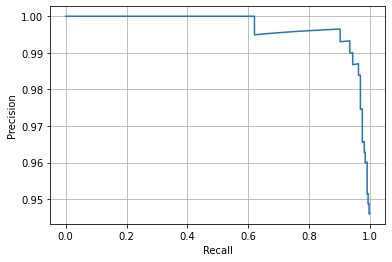

In [23]:
val_prob = predict(x=x_test, w=weights, return_prob=True)
precision, recall, thresholds = precision_recall_curve(y_test, val_prob)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()

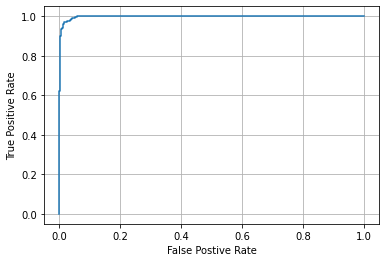

In [24]:
fpr, tpr, thresholds = roc_curve(y_test, val_prob)

plt.plot(fpr, tpr)
plt.xlabel("False Postive Rate")
plt.ylabel("True Positive Rate")
plt.grid()

In [25]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=100).fit(x, y)

val_prob = clf.predict_proba(x_test)
val_predict = np.argmax(val_prob, axis=1)
val_acc = (val_predict == y_test).sum()/y_test.shape[0]

val_acc

0.9684044233807267

In [26]:
num_epochs = 1000
batch_size = 64
weights = np.random.normal(loc=0, scale=np.sqrt(2/(x.shape[1])), size=x.shape[1]-1)
weights = np.append(weights, 0.)
alpha = 1e-1
min_val_cost = np.inf
patience = 0
max_weights = weights
for i in range(num_epochs):
    index = np.arange(x_train.shape[0])
    np.random.shuffle(index)
    for j in range(ceil(x_train.shape[0]/64)):
        index_batch = index[j * batch_size: j * batch_size + batch_size]
        x_batch = x_train[index_batch]
        y_batch = y_train[index_batch]
        #x_batch = x_train[j * batch_size: j * batch_size + batch_size]
        #y_batch = y_train[j * batch_size: j * batch_size + batch_size]
        #print(x_batch.shape, y_batch.shape)

        dweights = derivative_cost_wrt_params(x=x_batch, w=weights, y=y_batch)
        alpha = backtracking_line_search(x=x_batch, w=weights, y=y_batch, p=-dweights, rho=0.9, alpha=1e-1, c=0.0001)
        #print(alpha)
        weights -= alpha * dweights

        cost = sigmoid_cross_entropy_with_x_w(x=x_batch, w=weights, y=y_batch)
        
        tr_output = predict(x=x_batch, w=weights, threshold=0.6).astype(np.float)
        tr_acc = (tr_output == y_batch).sum()/y_batch.shape[0]
        #print(i, j, cost, tr_acc)

    cost = sigmoid_cross_entropy_with_x_w(x=x_train, w=weights, y=y_train)
    tr_output = predict(x=x_train, w=weights, threshold=0.6).astype(np.float)
    tr_acc = (tr_output == y_train).sum()/y_train.shape[0]
    val_cost = sigmoid_cross_entropy_with_x_w(x=x_test, w=weights, y=y_test)
    val_output = predict(x=x_test, w=weights, threshold=0.6).astype(np.float)
    val_acc = (val_output == y_test).sum()/y_test.shape[0]
    print(i, cost, tr_acc, val_cost, val_acc)
    #if val_cost < min_val_cost:
    #    min_val_cost = val_cost
    #    patience = 0
    #    max_weights = weights
    #else:
    #    patience += 1
#
    ##if patience >= 20 and np.allclose(dweights, np.zeros_like(dweights), rtol=1e-3, atol=1e-5):
    #if patience >= 100:
    #    weights = max_weights
    #    print("Stop at epoch {}, restore weights".format(i))
    #    break

0 0.684127829700543 0.4911242603550296 0.6693802367060003 0.4913112164296998
1 0.613451844840315 0.5151873767258383 0.6266197087061978 0.4881516587677725
2 0.5675140945007979 0.5798816568047337 0.5969403497615615 0.5165876777251185
3 0.5348355239338107 0.6481262327416174 0.5748309312624084 0.5639810426540285
4 0.5099379013091195 0.6863905325443787 0.5571531083612223 0.6018957345971564
5 0.49101177524584777 0.6824457593688363 0.5434485587925789 0.593996840442338
6 0.4736711028031706 0.7424063116370808 0.5289156004042885 0.7093206951026856
7 0.4593968898557074 0.7439842209072979 0.5170240318056263 0.7030015797788309
8 0.4469008750257844 0.7625246548323471 0.5059145078516692 0.7235387045813586
9 0.4360712771589768 0.7554240631163708 0.49599061335941114 0.7140600315955766
10 0.4258764520390308 0.7644970414201183 0.4863177794390918 0.7235387045813586
11 0.4159153784238625 0.7940828402366864 0.4763592294882117 0.7677725118483413
12 0.4071135315280874 0.809861932938856 0.46743299449316916 0.7

In [27]:
weights

array([  1.22878353,   1.85145644,  -1.41572349,  -2.48119672,
         3.75209885,   6.54263667,  -1.50595608,  -1.04612589,
         5.10814143,  -4.08710516,   0.55474731,   1.03473272,
       -22.11467264,   2.38899423,  -0.41094809,   0.32706485,
         0.75712319,   0.1667968 ,   0.39633477,  -0.48738193,
         3.63024014])

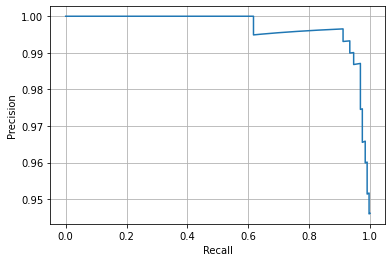

In [28]:
val_prob = predict(x=x_test, w=weights, return_prob=True)
precision, recall, thresholds = precision_recall_curve(y_test, val_prob)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()

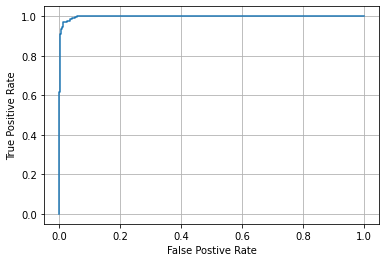

In [29]:
fpr, tpr, thresholds = roc_curve(y_test, val_prob)

plt.plot(fpr, tpr)
plt.xlabel("False Postive Rate")
plt.ylabel("True Positive Rate")
plt.grid()

In [30]:
num_epochs = 500
batch_size = 1
weights = np.random.normal(loc=0, scale=np.sqrt(2/(x.shape[1])), size=x.shape[1]-1)
weights = np.append(weights, 0.)
alpha = 1e-1
min_val_cost = np.inf
patience = 0
max_weights = weights
for i in range(num_epochs):
    index = np.arange(x_train.shape[0])
    np.random.shuffle(index)
    for j in range(ceil(x_train.shape[0]/64)):
        index_batch = index[j * batch_size: j * batch_size + batch_size]
        x_batch = x_train[index_batch]
        y_batch = y_train[index_batch]
        #x_batch = x_train[j * batch_size: j * batch_size + batch_size]
        #y_batch = y_train[j * batch_size: j * batch_size + batch_size]
        #print(x_batch.shape, y_batch.shape)

        dweights = derivative_cost_wrt_params(x=x_batch, w=weights, y=y_batch)
        alpha = backtracking_line_search(x=x_batch, w=weights, y=y_batch, p=-dweights, rho=0.9, alpha=1e-1, c=0.0001)
        #print(alpha)
        weights -= alpha * dweights

        cost = sigmoid_cross_entropy_with_x_w(x=x_batch, w=weights, y=y_batch)
        
        tr_output = predict(x=x_batch, w=weights, threshold=0.6).astype(np.float)
        tr_acc = (tr_output == y_batch).sum()/y_batch.shape[0]
        #print(i, j, cost, tr_acc)

    cost = sigmoid_cross_entropy_with_x_w(x=x_train, w=weights, y=y_train)
    tr_output = predict(x=x_train, w=weights, threshold=0.6).astype(np.float)
    tr_acc = (tr_output == y_train).sum()/y_train.shape[0]
    val_cost = sigmoid_cross_entropy_with_x_w(x=x_test, w=weights, y=y_test)
    val_output = predict(x=x_test, w=weights, threshold=0.6).astype(np.float)
    val_acc = (val_output == y_test).sum()/y_test.shape[0]
    print(i, cost, tr_acc, val_cost, val_acc)
    #if val_cost < min_val_cost:
    #    min_val_cost = val_cost
    #    patience = 0
    #    max_weights = weights
    #else:
    #    patience += 1
#
    ##if patience >= 20 and np.allclose(dweights, np.zeros_like(dweights), rtol=1e-3, atol=1e-5):
    #if patience >= 100:
    #    weights = max_weights
    #    print("Stop at epoch {}, restore weights".format(i))
    #    break

0 0.6433834035474117 0.7017751479289941 0.6897876297164073 0.5387045813586098
1 0.6356869778740958 0.798422090729783 0.7019825171723388 0.6856240126382307
2 0.5329062803502633 0.6887573964497041 0.6079369130234972 0.5971563981042654
3 0.5541873555915602 0.8690335305719921 0.6261330551321578 0.7898894154818326
4 0.49808152119335525 0.7648915187376726 0.5739212340812906 0.7045813586097947
5 0.6108461379093493 0.7834319526627219 0.70507942137831 0.674565560821485
6 0.4658040510672457 0.7045364891518737 0.5482724627595494 0.6145339652448657
7 0.48962582874349564 0.8792899408284024 0.5769020215049082 0.8214849921011058
8 0.4409874596590619 0.7317554240631163 0.5161374746311782 0.631911532385466
9 0.4350914454202707 0.726232741617357 0.5097564060170323 0.6208530805687204
10 0.419538395232582 0.798422090729783 0.4873949809254476 0.740916271721959
11 0.4083286012141709 0.8106508875739645 0.4793187645604411 0.7709320695102686
12 0.4421013244590826 0.6832347140039448 0.5127639345444831 0.5797788

In [31]:
weights, dweights

(array([  0.76742974,   1.6587324 ,  -0.38000525,  -2.04336707,
          3.09674147,   5.83272759,  -0.88495115,  -0.89272512,
          4.26154346,  -2.62494277,   0.75077992,   1.10693464,
        -19.00065293,   1.81032229,  -0.52368012,   0.56135458,
          0.38525173,   0.30210236,   0.37079578,  -0.11160221,
          2.24870098]),
 array([0.03424054, 0.04683941, 0.04626898, 0.01621966, 0.05079382,
        0.0413986 , 0.00400566, 0.00030839, 0.06666827, 0.06257328,
        0.05368887, 0.03424054, 0.05289968, 0.00939847, 0.06684835,
        0.01209891, 0.00048986, 0.01101746, 0.01102534, 0.01468951,
        0.07592819]))

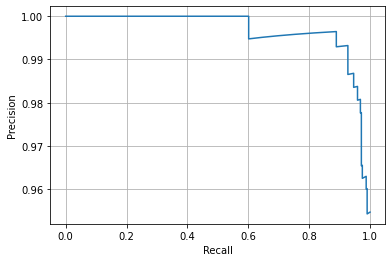

In [32]:
val_prob = predict(x=x_test, w=weights, return_prob=True)
precision, recall, thresholds = precision_recall_curve(y_test, val_prob)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()

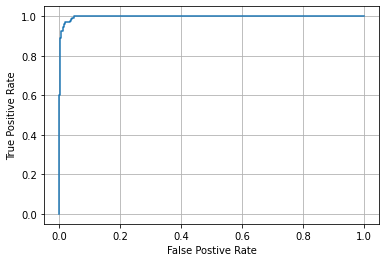

In [33]:
fpr, tpr, thresholds = roc_curve(y_test, val_prob)

plt.plot(fpr, tpr)
plt.xlabel("False Postive Rate")
plt.ylabel("True Positive Rate")
plt.grid()